# Lesson: Natural Language Processing - Exploration

### EDA question: How do we quantify our data/text
we will explore using spam/ham text message; word frequency, ngrams, word cloud, sentiment analysis, other features

In [3]:
# imports
import re
import unicodedata
import nltk
from wordcloud import WordCloud

import os 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from env import get_connection

In [4]:
# Get SQL database url 
url = get_connection('spam_db')

In [5]:
#Define SQL query
query = '''
    SELECT *
    FROM spam
    '''

In [6]:
df = pd.read_sql(query, url, index_col='id')

In [8]:
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
#Value counts of labels 
df['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

in the context of a classification problem we may ask 
* what leads to a spam text?
* what leads to a ham text?

In [16]:
df.iloc[0].text

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

* recall how the string method join operates -- glues together
* all instances inside of a iterable using whatever is specified
* ahead of method call:
* english: glue these words together with a emptyspace

In [17]:
' '.join(['this', 'is', 'python'])

'this is python'

In [20]:
ADDITIONAL_STOPWORDS = ['r','u','2','4','ltgt']
def clean(text):
    '''
    * a simple function to cleanup text data
    * Arguemnt is text(str): the text tobe cleaned
    * Returns a list of lemmatized wordsafter cleaning
    '''
    # basic_clean() function from last lesson:
    # Normalize text by removingdiacritics, encoding to ASCII
    # Decode to UTF-8
    text = (unicodedata.normalize('NFKD',text)
           .encode('ascii', 'ignore')
           .decode('utf-8', 'ignore')
           .lower())
    # remove punctuation, split text into words
    words = re.sub(r'[^\w\s]','', text).split()
    
    #lemmatize() function from last lesson:
    # Initialized WordNet lemmatizer
    wnl=nltk.stem.WordNetLemmatizer()
    
    #Combine standard English stopwords with additional stopwords
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    
    # Lemmatize words and remove stopwords
    cleaned_words = [wnl.lemmatize(word) for word in words if word not in stopwords]
    return cleaned_words

In [24]:
# we can do that process witha join on Series and not just a list
# we will do that for ham words, spam words, and all words
# we will pass our basic cleaning on top of that

ham_words = clean(' '.join(df[df.label=="ham"]['text']))
spam_words = clean(' '.join(df[df.label=="spam"]['text']))
all_words = clean(' '.join(df['text']))

In [25]:
len(all_words), len(spam_words), len(ham_words)

(50018, 12044, 37974)

In [28]:
# to get some sights on word frequency by taking our words back apart
# we will split each set of words by the spaces
# turn that into a list, cast that list as a Series
# and then take the value counts of that Series
# We will do this for each type of word present

ham_freq=pd.Series(ham_words).value_counts()
spam_freq=pd.Series(spam_words).value_counts()
all_freq=pd.Series(all_words).value_counts()


In [31]:
all_freq

call             600
im               462
get              397
ur               384
go               304
                ... 
cage               1
surrounded         1
cuck               1
weeddeficient      1
bitching           1
Length: 8899, dtype: int64

# Exploration

representtextas word frequencies
* concat all frequencies together intoa dataframe

In [32]:
ham_freq

im            449
get           314
go            273
ok            272
dont          257
             ... 
gained          1
surrounded      1
pressure        1
cage            1
bitching        1
Length: 6981, dtype: int64

In [33]:
pd.concat([ham_freq,spam_freq,all_freq], axis=1).fillna(0).astype(int)

,0,1,2
im,449,13,462
get,314,83,397
go,273,31,304
ok,272,5,277
dont,257,22,279
...,...,...,...
resub,0,1,1
expired,0,1,1
9153,0,1,1
okmail,0,1,1


In [34]:
# combine all 3 dfs horizontally
# fill any missing values with zero
# convert the resulting df to contain only integer values:

word_counts = pd.concat([ham_freq,spam_freq,all_freq], axis=1).fillna(0).astype(int)

In [36]:
word_counts.columns = ['ham','spam','all']
word_counts.head()

,ham,spam,all
im,449,13,462
get,314,83,397
go,273,31,304
ok,272,5,277
dont,257,22,279


In [37]:
word_counts.sample(5).head()

,ham,spam,all
checkboxes,1,0,1
mandan,2,0,2
shopwe,1,0,1
report,6,0,6
150pday,0,2,2


* what are the most frequently occuring words?
* are there any words that uniquely identify a spam or ham message?


In [39]:
# sort by 'all'
word_counts.sort_values('all', ascending=False)

,ham,spam,all
call,241,359,600
im,449,13,462
get,314,83,397
ur,240,144,384
go,273,31,304
...,...,...,...
edition,1,0,1
algorithm,1,0,1
textbook,1,0,1
3230,1,0,1


In [42]:
# sort by 'ham' and 'spam' columns
word_counts.sort_values(['ham','spam','all'],ascending=False)

,ham,spam,all
im,449,13,462
get,314,83,397
go,273,31,304
ok,272,5,277
dont,257,22,279
...,...,...,...
resub,0,1,1
expired,0,1,1
9153,0,1,1
okmail,0,1,1


# Visualization
* ham vs spam count for 20 most common words
* ham vs spam proportion for 20 most commmon words

In [44]:
# setting basic style parameters for matplotlib
plt.rc('figure', figsize= (13,7))
plt.style.use('seaborn-darkgrid')

/var/folders/mn/mp1xhgm522gc5vhffb_k61d00000gn/T/ipykernel_48968/3460494083.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


<Axes: >

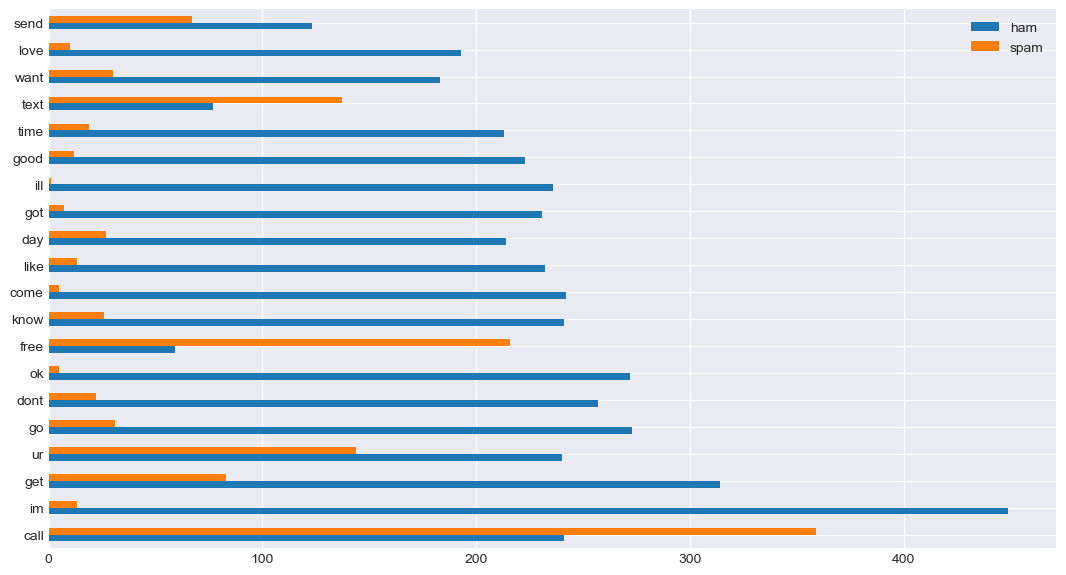

In [45]:
word_counts.sort_values('all', ascending=False)[['ham','spam']].head(20).plot.barh()

In [46]:
word_counts.sort_values('all',ascending=False).head(20)\
.apply(lambda row: row/row['all'],axis=1)

,ham,spam,all
call,0.401667,0.598333,1.0
im,0.971861,0.028139,1.0
get,0.790932,0.209068,1.0
ur,0.625000,0.375000,1.0
go,0.898026,0.101974,1.0
dont,0.921147,0.078853,1.0
ok,0.981949,0.018051,1.0
free,0.214545,0.785455,1.0
know,0.902622,0.097378,1.0
come,0.979757,0.020243,1.0


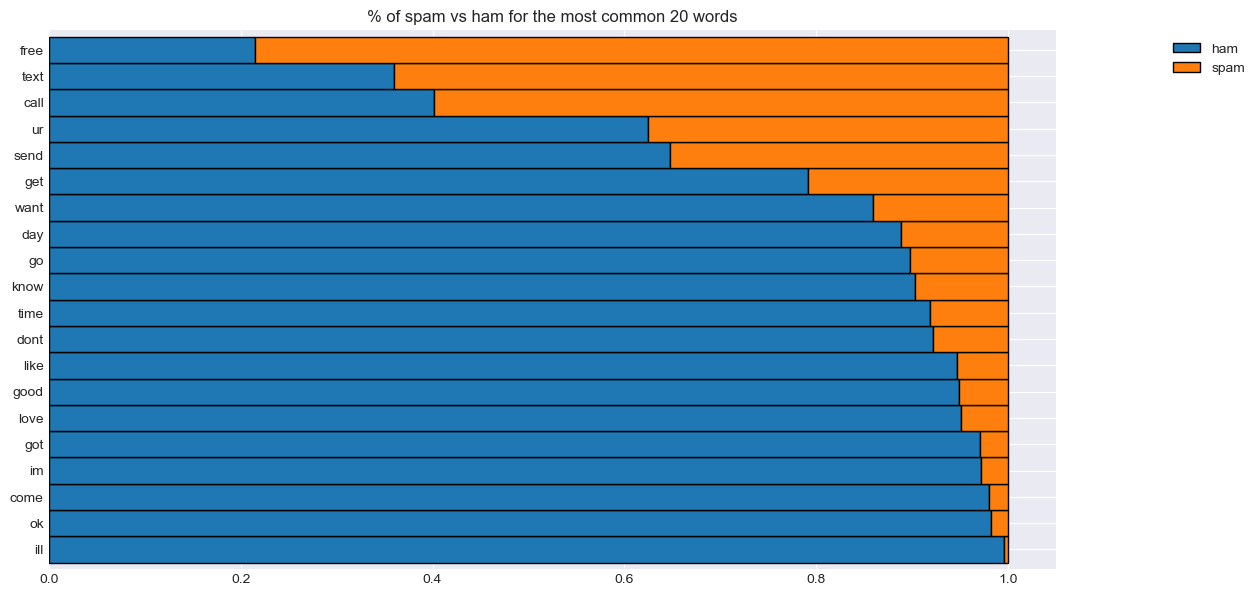

In [47]:
(word_counts.sort_values('all', ascending=False)
.head(20)
.apply(lambda row: row/row['all'], axis=1)
.drop(columns='all')
.sort_values(by='spam')
.plot.barh(stacked=True, width=1, ec='black')
)


plt.title('% of spam vs ham for the most common 20 words')
plt.legend(bbox_to_anchor=(1.2, 1.0),loc='upper right')
plt.show()

# n-grams

bigram: combinations of 2 words

* represent text as combinations of 2 words

In [49]:
sentence = 'Today is Monday ! ! ! and the weather is ok. '

In [50]:
list(nltk.bigrams(sentence.split()))

[('Today', 'is'),
 ('is', 'Monday'),
 ('Monday', '!'),
 ('!', '!'),
 ('!', '!'),
 ('!', 'and'),
 ('and', 'the'),
 ('the', 'weather'),
 ('weather', 'is'),
 ('is', 'ok.')]

In [52]:
# make sure to make bigrams out of words; spam bigrams and ham bigrams
# visualize 20 most common bigrams
# ngrams
list(nltk.ngrams(sentence.split(),3))

[('Today', 'is', 'Monday'),
 ('is', 'Monday', '!'),
 ('Monday', '!', '!'),
 ('!', '!', '!'),
 ('!', '!', 'and'),
 ('!', 'and', 'the'),
 ('and', 'the', 'weather'),
 ('the', 'weather', 'is'),
 ('weather', 'is', 'ok.')]

<Axes: >

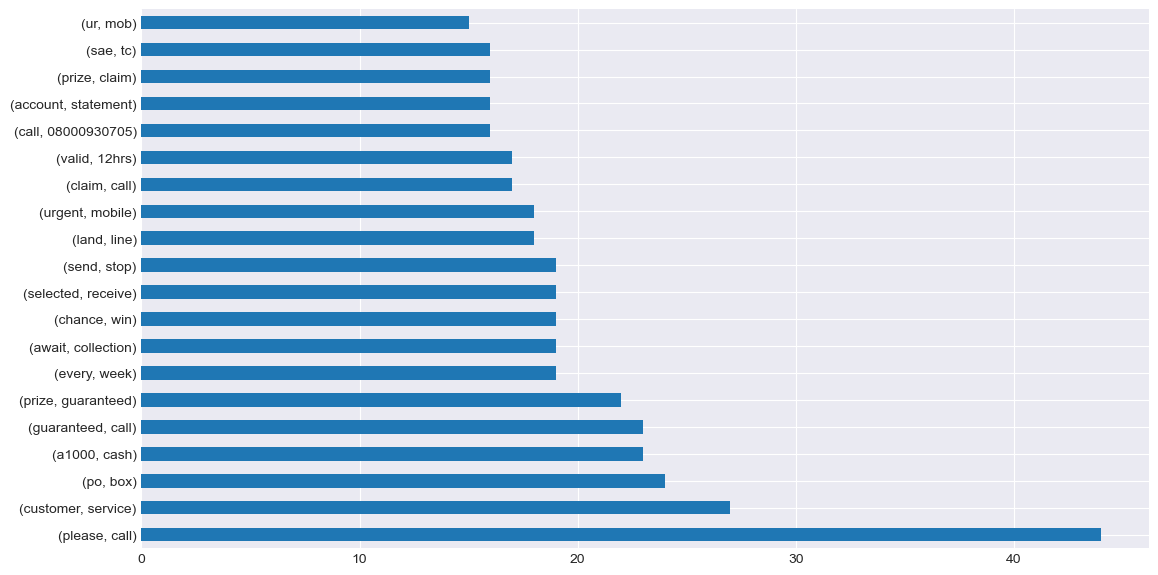

In [53]:
pd.Series(nltk.bigrams(spam_words)).value_counts().head(20).plot.barh()

# Words Cloud

### Making a word cloud:
1. Call WordCloud.generate
2. reference a string withall words, not a list or series
3. call plt.imshow on the generation from wordcloud

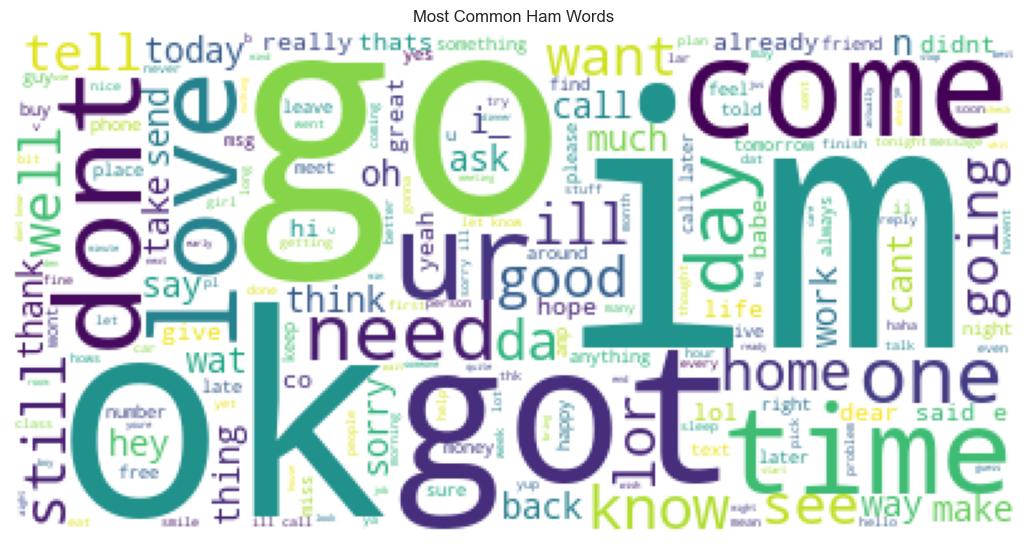

In [55]:
img = WordCloud(background_color='white').generate(' '.join(ham_words))

plt.imshow(img)
plt.axis('off')
plt.title('Most Common Ham Words')
plt.show()

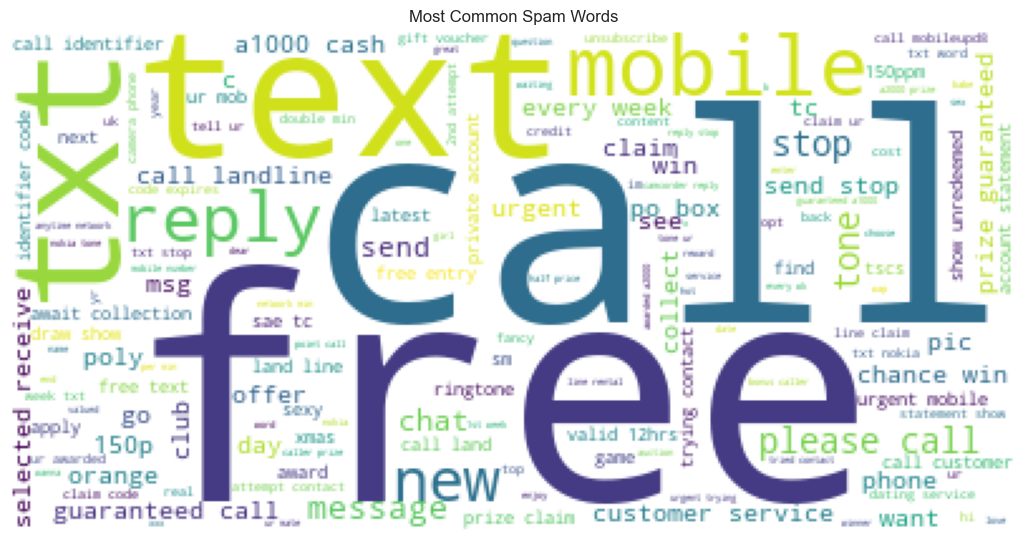

In [56]:
img = WordCloud(background_color='white').generate(' '.join(spam_words))

plt.imshow(img)
plt.axis('off')
plt.title('Most Common Spam Words')
plt.show()

# Other Common Features
Any NLP dataset will have domain specific features, for example: number of retweets, number of @mentions, number of upvotes, or mean time to respond to a support chat. In addition to these domain specific features, some common measures for a document are:

* character count
* word count
* sentence count
* stopword count
* unique word count
* punctuation count
* average word length
* average words per sentence
* word to stopword ratio

Create one or more of the above features and visualize it.

In [58]:
# add two new columns 'message_length' and 'word_count'

df['message_length'] = df['text'].str.len()

In [59]:
# we apply our clean function, apply len chained on it
# if we did not want to clean this before word count, we would want to do a split on it

df['word_count'] = df.text.apply(clean).apply(len)

In [60]:
df.head()

,label,text,message_length,word_count
id,,,,
0,ham,"Go until jurong point, crazy.. Available only ...",111,16
1,ham,Ok lar... Joking wif u oni...,29,5
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,22
3,ham,U dun say so early hor... U c already then say...,49,7
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,8



# Sentiment

A number indicating whether the document is positive or negative.

* knowledge-based + statistical approach
* relies on human-labelled data
* combination of qualitative and quantitative methods
*  then empirically validate
*  different models for diff domains (e.g. social media vs news)
* for social media
*  Afinn (github + whitepaper)
*  Vader (github + whitepaper)nltk.sentiment.vader.SentimentIntensityAnalyzer. Pre-trained sentiment analyzer (Valence Aware Dictionary and sEntiment Reasoner).)
From your terminal: python -c 'import nltk;nltk.download("vader_lexicon")'

In [62]:
import nltk.sentiment


In [65]:
sia = nltk.sentiment.SentimentIntensityAnalyzer()

In [66]:
sia.polarity_scores('He is really good')


{'neg': 0.0, 'neu': 0.484, 'pos': 0.516, 'compound': 0.4927}

In [67]:
sia.polarity_scores('The food is good but service is slow')


{'neg': 0.0, 'neu': 0.782, 'pos': 0.218, 'compound': 0.2382}

In [68]:
sia.polarity_scores('I hate you')


{'neg': 0.787, 'neu': 0.213, 'pos': 0.0, 'compound': -0.5719}

In [69]:
sia.polarity_scores('I hate you :)')


{'neg': 0.481, 'neu': 0.13, 'pos': 0.39, 'compound': -0.1779}

In [70]:
sia.polarity_scores('I hate hate speech')


{'neg': 0.881, 'neu': 0.119, 'pos': 0.0, 'compound': -0.8126}

In [71]:
sia.polarity_scores('I hate hate speech (^_^)')


{'neg': 0.787, 'neu': 0.213, 'pos': 0.0, 'compound': -0.8126}

In [72]:
sia.polarity_scores('He is a bad, bad man')


{'neg': 0.7, 'neu': 0.3, 'pos': 0.0, 'compound': -0.7906}

In [73]:
sia.polarity_scores('bad bad bad bad bad bad bad hate most bad')


{'neg': 0.969, 'neu': 0.031, 'pos': 0.0, 'compound': -0.9858}

In [74]:
sia.polarity_scores('HATE, HATE, HATE, LOATHE ENTIRELY')


{'neg': 0.935, 'neu': 0.065, 'pos': 0.0, 'compound': -0.936}

In [75]:
sia.polarity_scores('death')


{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.5994}

Things that can influence Sentiment Score:

1. Punctuations. Can increase the intensity
2. Capitalization. Can increase the intensity
3. Degree modifiers
4. Conjunctions

It can handle Emojis and slangs

Apply this to the text message data



In [77]:
# grab the sentiment from each of the texts as they stand:
# apply a lambda function on each cell in the text column:
# polarity_score's value associtated with the "compound"
# key for each score

df['sentiment'] = df['text'].apply(lambda doc: sia.polarity_scores(doc)['compound'])
df.head()

,label,text,message_length,word_count,sentiment
id,,,,,
0,ham,"Go until jurong point, crazy.. Available only ...",111,16,0.6249
1,ham,Ok lar... Joking wif u oni...,29,5,0.4767
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,22,0.7964
3,ham,U dun say so early hor... U c already then say...,49,7,0.0000
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,8,-0.1027


In [78]:
# is the mean and median values of sentiment score different for ham vs spam?

df.groupby('label').sentiment.agg(['mean','median'])

,mean,median
label,,
ham,0.152218,0.0000
spam,0.436018,0.6107


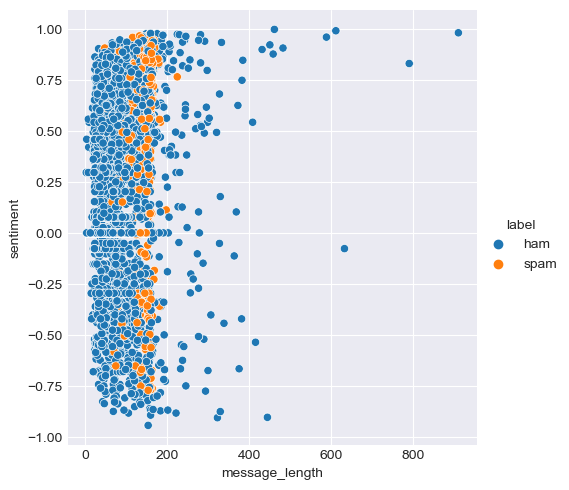

In [79]:
#plot message_length vs sentiment and hue by label

sns.relplot(data=df, x='message_length', y='sentiment', hue='label')

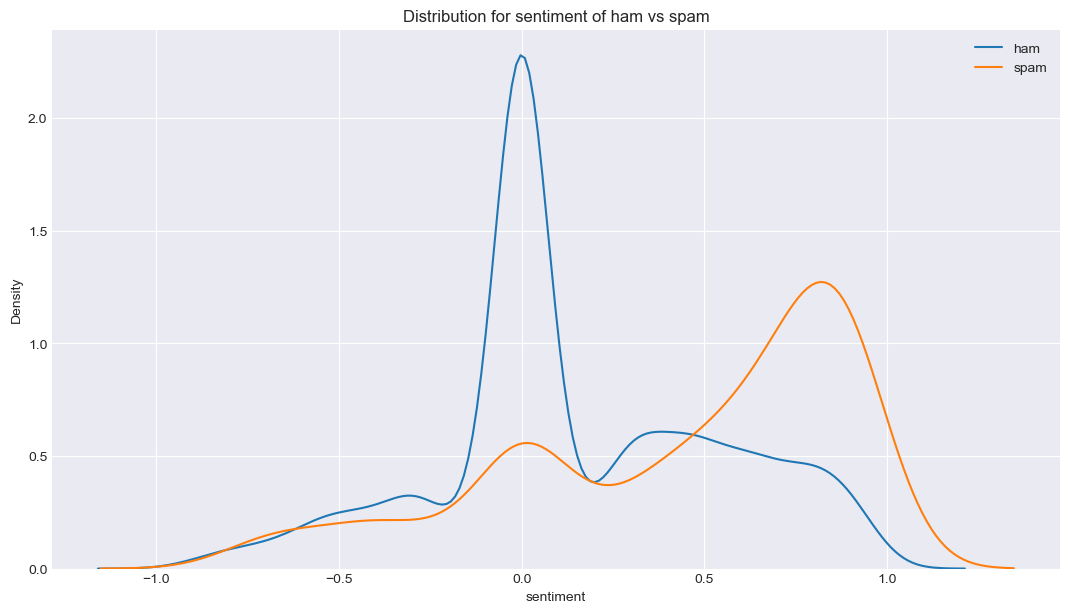

In [80]:
# is the distribution for sentiment different for ham vs spam

sns.kdeplot(df[df.label=='ham'].sentiment, label='ham')
sns.kdeplot(df[df.label=='spam'].sentiment, label='spam')

plt.legend(['ham', 'spam'])
plt.title("Distribution for sentiment of ham vs spam")
plt.show()

/var/folders/mn/mp1xhgm522gc5vhffb_k61d00000gn/T/ipykernel_48968/2194897636.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
/var/folders/mn/mp1xhgm522gc5vhffb_k61d00000gn/T/ipykernel_48968/2194897636.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


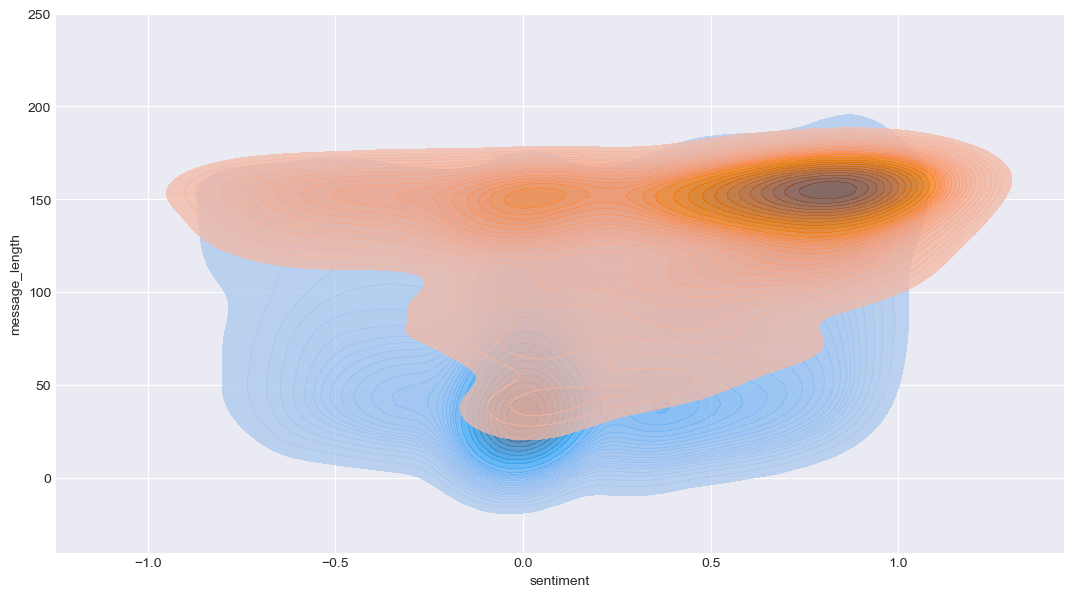

In [81]:
# Bivariate KDE plot for message_length vs sentiment score 
sns.kdeplot(
    x=df[df.label == 'ham'].sentiment,
    y=df[df.label == 'ham'].message_length, 
    levels = 30, shade = True, alpha=0.75);

sns.kdeplot(
    x=df[df.label == 'spam'].sentiment,
    y=df[df.label == 'spam'].message_length, 
    levels = 30, shade = True, alpha=0.75)

plt.ylim(top=250)
plt.show()

# Takeaways:
* Spam messages seem to have roughly the same message length, where ham varies a lot.
* Spam messages have a very positive sentiment
* If we wanted to utilize these features for modeling, we would want to proceed forward with means testing to establish their viability